<a href="https://www.kaggle.com/code/subhadipde2000/playground-s04e09-xgbregressor-eda?scriptVersionId=194942610" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Used Car Price Prediction

Welcome to this Jupyter Notebook project aimed at predicting the prices of used cars. This notebook contains extensive Exploratory Data Analysis (EDA) and employs the XGBRegressor model to predict car prices based on various factors such as model year, brand, mileage, engine specifications, and more.

The goal of this project is to build a robust predictive model that can help potential buyers and sellers estimate the value of used cars accurately. By leveraging machine learning techniques, we aim to uncover insights and patterns within the data that can inform better decision-making in the used car market.

Let's dive into the data and explore the steps involved in building and evaluating our predictive model.

# Problem Statement

The used car market is highly dynamic and influenced by a multitude of factors, making it challenging to determine the fair price of a used car. Buyers and sellers often struggle to agree on a price due to the lack of a standardized pricing mechanism. This project aims to address this challenge by developing a predictive model that can estimate the price of a used car based on its attributes.

### Objectives:
1. **Data Preparation**: Preprocess data on used cars, including features such as model year, brand, mileage, engine specifications, and more.
2. **Exploratory Data Analysis (EDA)**: Conduct a thorough analysis of the data to understand the relationships between different features and the target variable (price).
3. **Feature Engineering**: Create new features or transform existing ones to improve the model's performance.
4. **Model Building**: Train an XGBRegressor model to predict used car prices.
5. **Model Evaluation**: Assess the performance of the model using appropriate metrics and validate its predictions.
6. **Insights and Recommendations**: Provide insights and recommendations based on the findings from the model and EDA.

By the end of this project, we aim to have a reliable predictive model that can assist buyers and sellers in making informed decisions about used car prices.

# Imports

In [1]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings("ignore")

# Reading in the dataframes

In [3]:
# Getting the file paths

filepaths = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepaths.append(os.path.join(dirname, filename))

filepaths

['/kaggle/input/playground-series-s4e9/sample_submission.csv',
 '/kaggle/input/playground-series-s4e9/train.csv',
 '/kaggle/input/playground-series-s4e9/test.csv']

In [4]:
# Defing the paths to training and test dataframes
train_dir, test_dir = filepaths[1], filepaths[2]

In [5]:
train_df = pd.read_csv(train_dir)
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [6]:
test_df = pd.read_csv(test_dir)
test_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


# EDA

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [8]:
for col in train_df.columns:
    print(f"{col} -> {train_df[col].isnull().sum()} null values\n")

id -> 0 null values

brand -> 0 null values

model -> 0 null values

model_year -> 0 null values

milage -> 0 null values

fuel_type -> 5083 null values

engine -> 0 null values

transmission -> 0 null values

ext_col -> 0 null values

int_col -> 0 null values

accident -> 2452 null values

clean_title -> 21419 null values

price -> 0 null values



In [9]:
for col in train_df.columns:
    if train_df[col].dtype == object:
        print(f"{col} -> {train_df[col].nunique()} unique values\n")

brand -> 57 unique values

model -> 1897 unique values

fuel_type -> 7 unique values

engine -> 1117 unique values

transmission -> 52 unique values

ext_col -> 319 unique values

int_col -> 156 unique values

accident -> 2 unique values

clean_title -> 1 unique values



In [10]:
def plot_count_plot(n, col, category=None, title=None, rotation='vertical'):
    global train_df
    top_n = train_df[col].value_counts().head(n).index
    df_top_n = train_df[train_df[col].isin(top_n)]
    
    plt.figure(figsize=(12, 6), dpi=150)
    plt.title(title) if title else None
    ax = sns.countplot(data=df_top_n, x=col, order=top_n, hue=category)
    ax.bar_label(ax.containers[0], fontsize=10);
    plt.xticks(rotation=rotation);

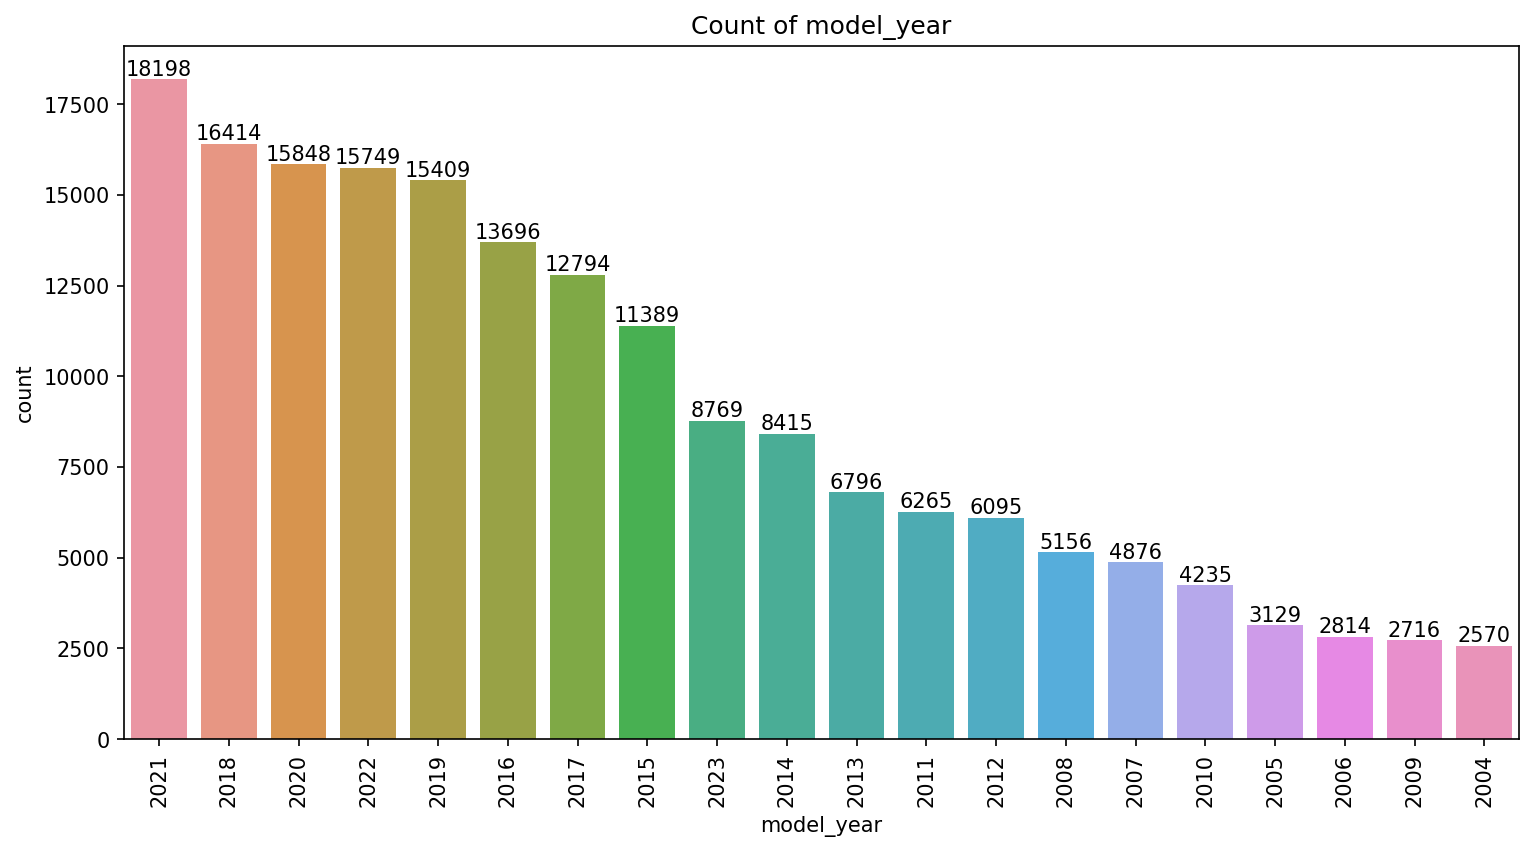

In [11]:
plot_count_plot(20, 'model_year', title='Count of model_year')

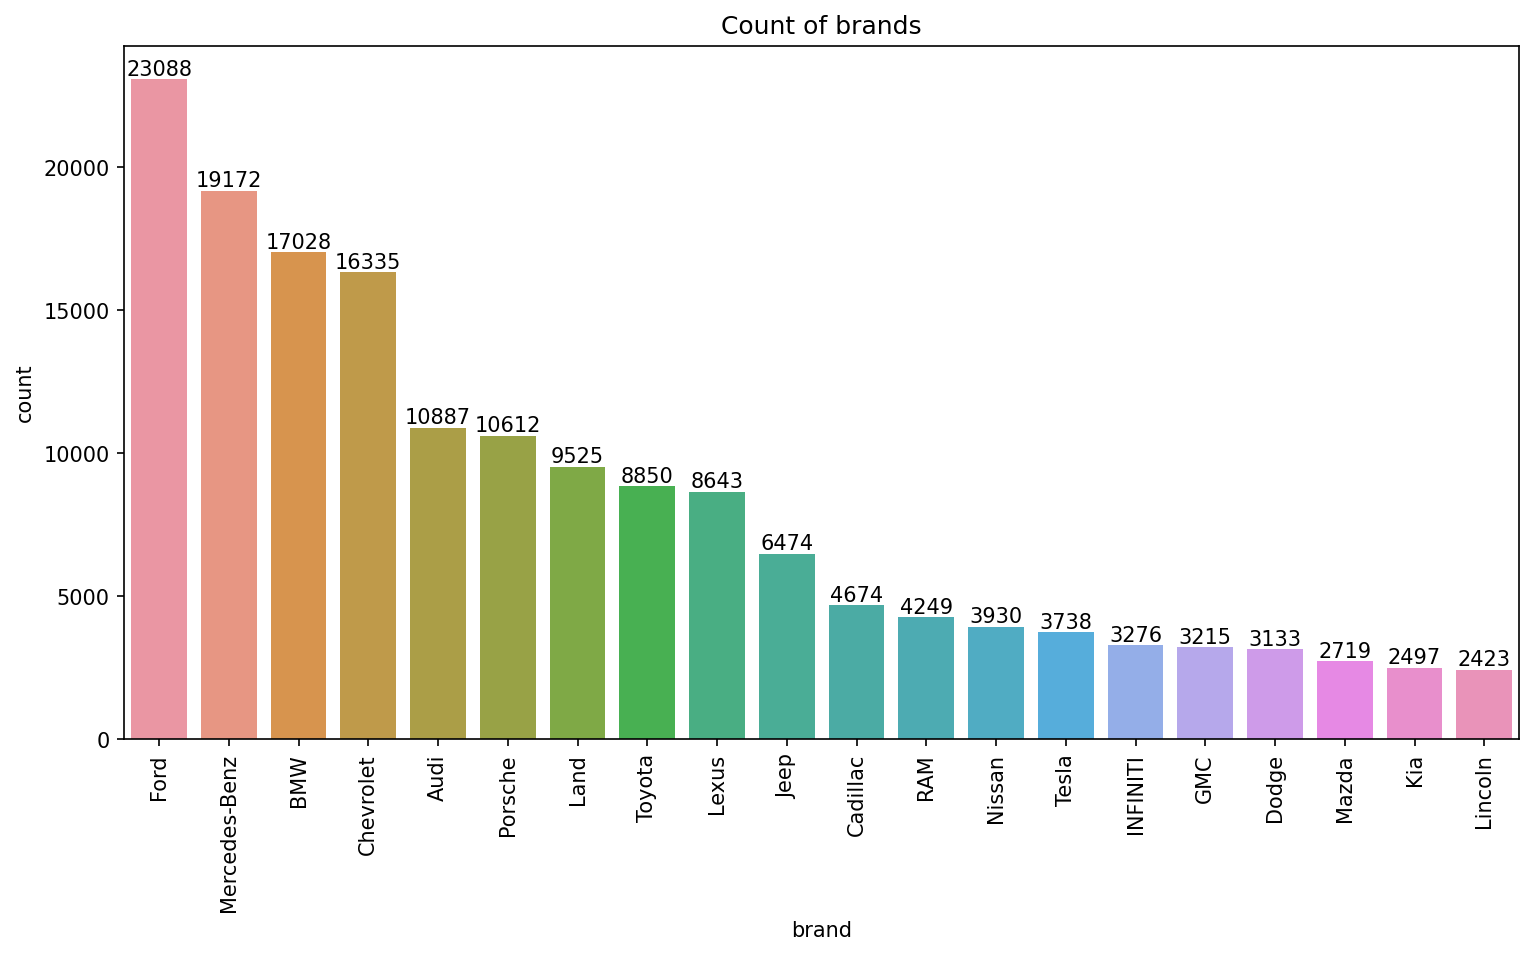

In [12]:
plot_count_plot(20, 'brand', title='Count of brands')

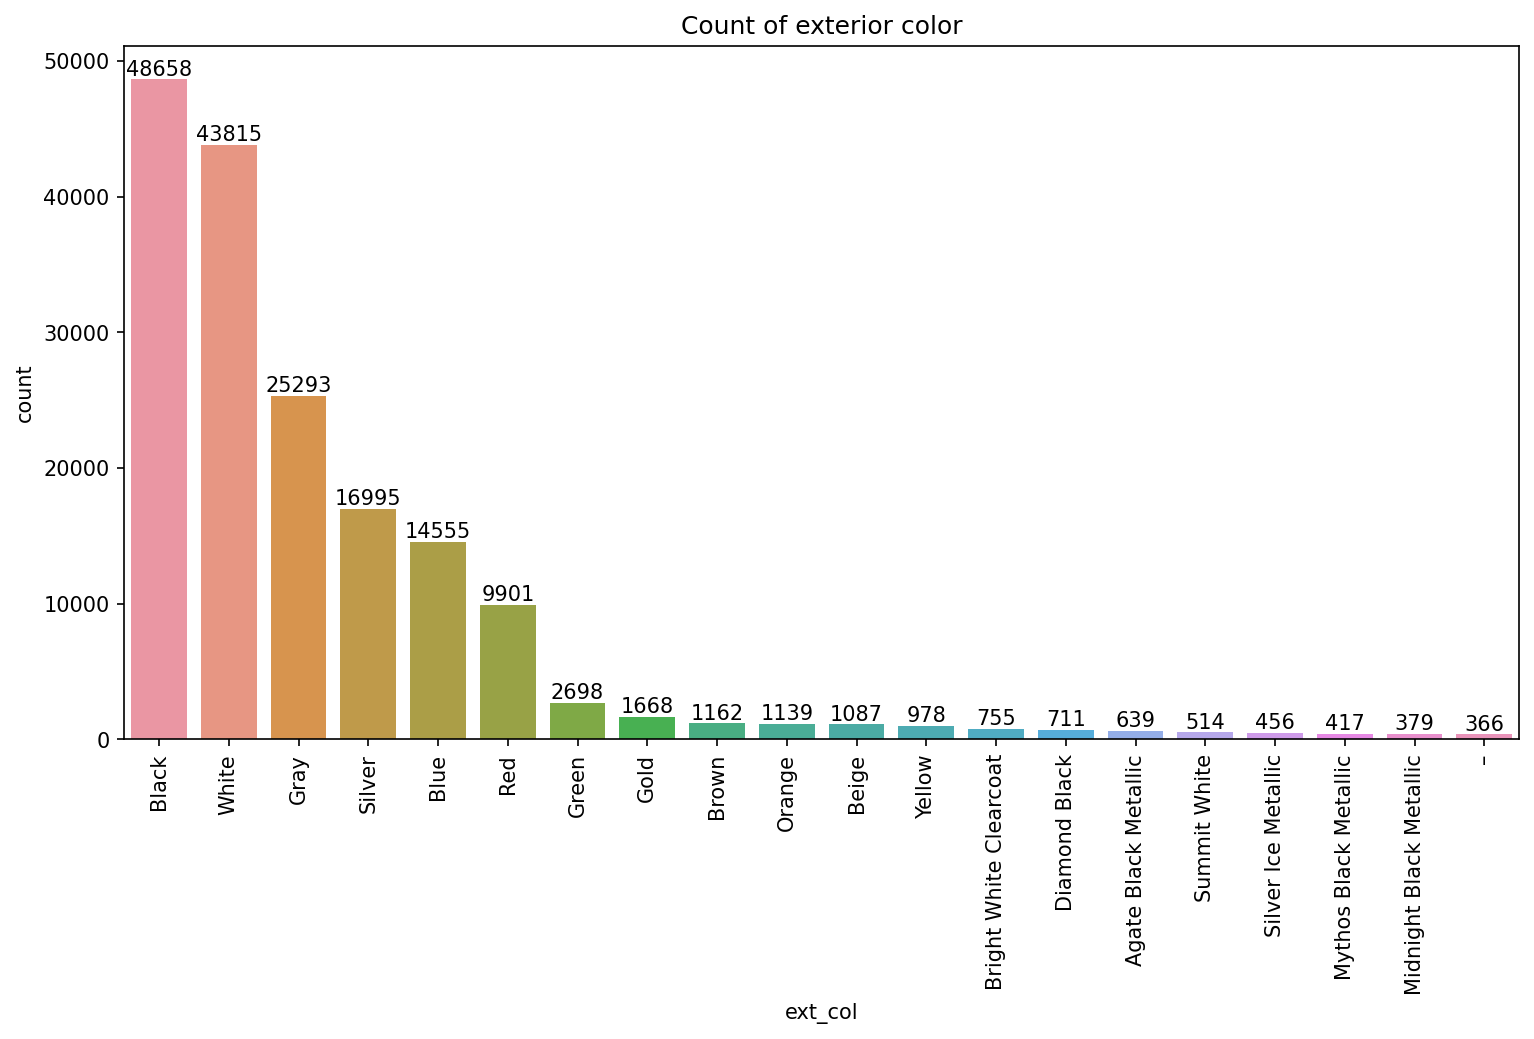

In [13]:
plot_count_plot(20, 'ext_col', title='Count of exterior color')

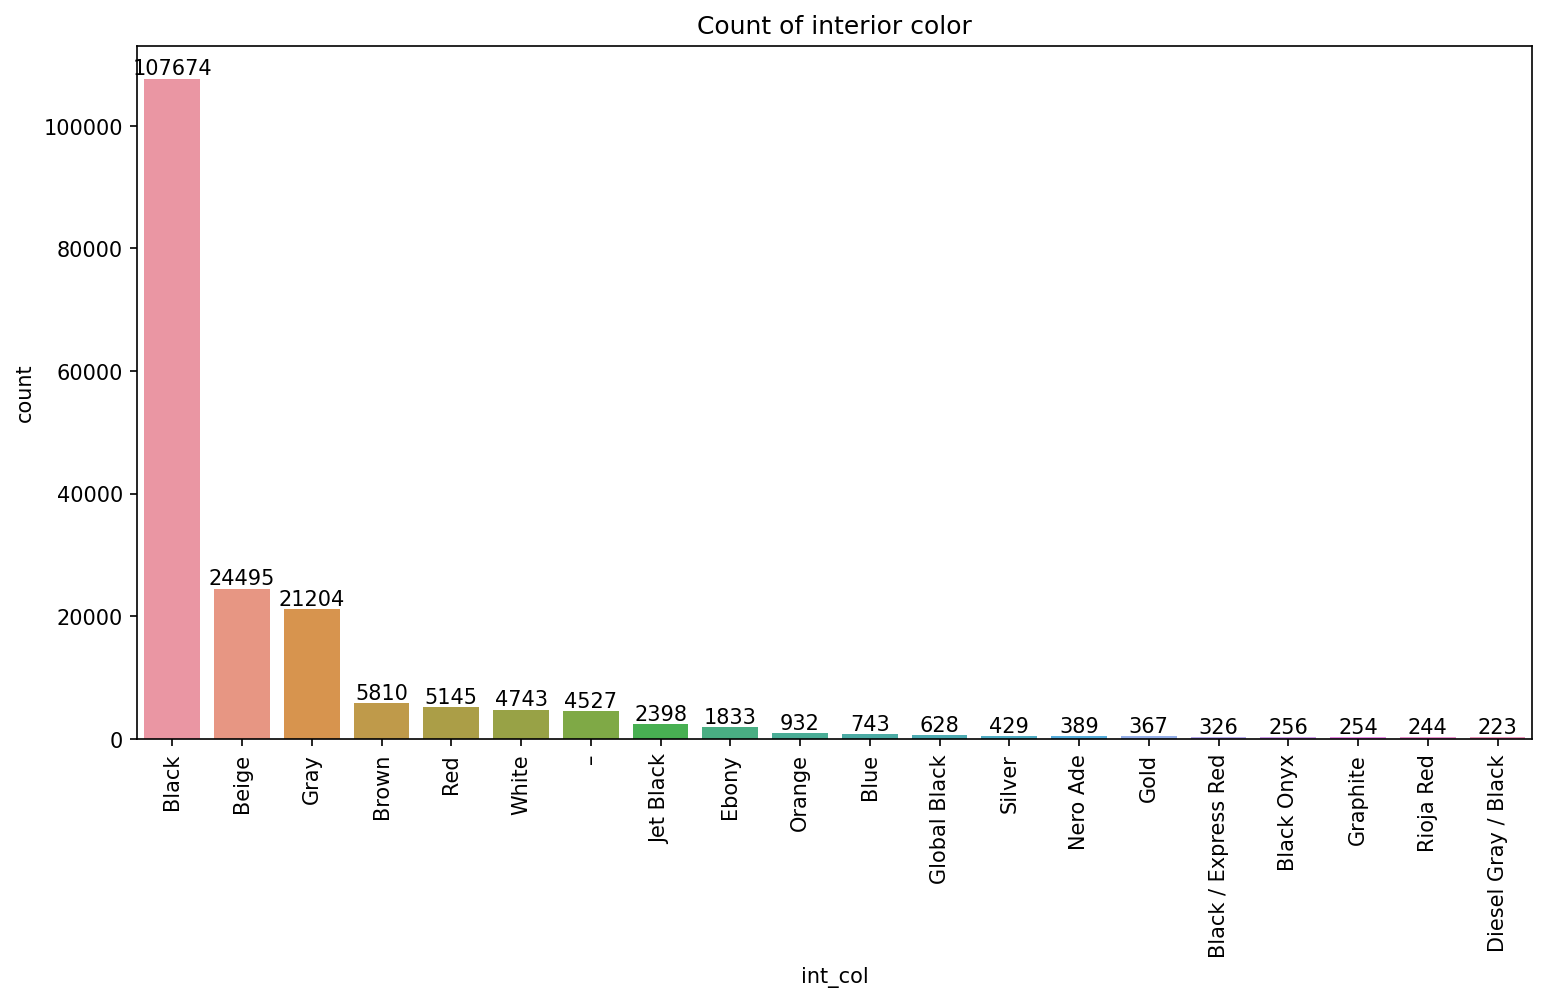

In [14]:
plot_count_plot(20, 'int_col', title='Count of interior color')

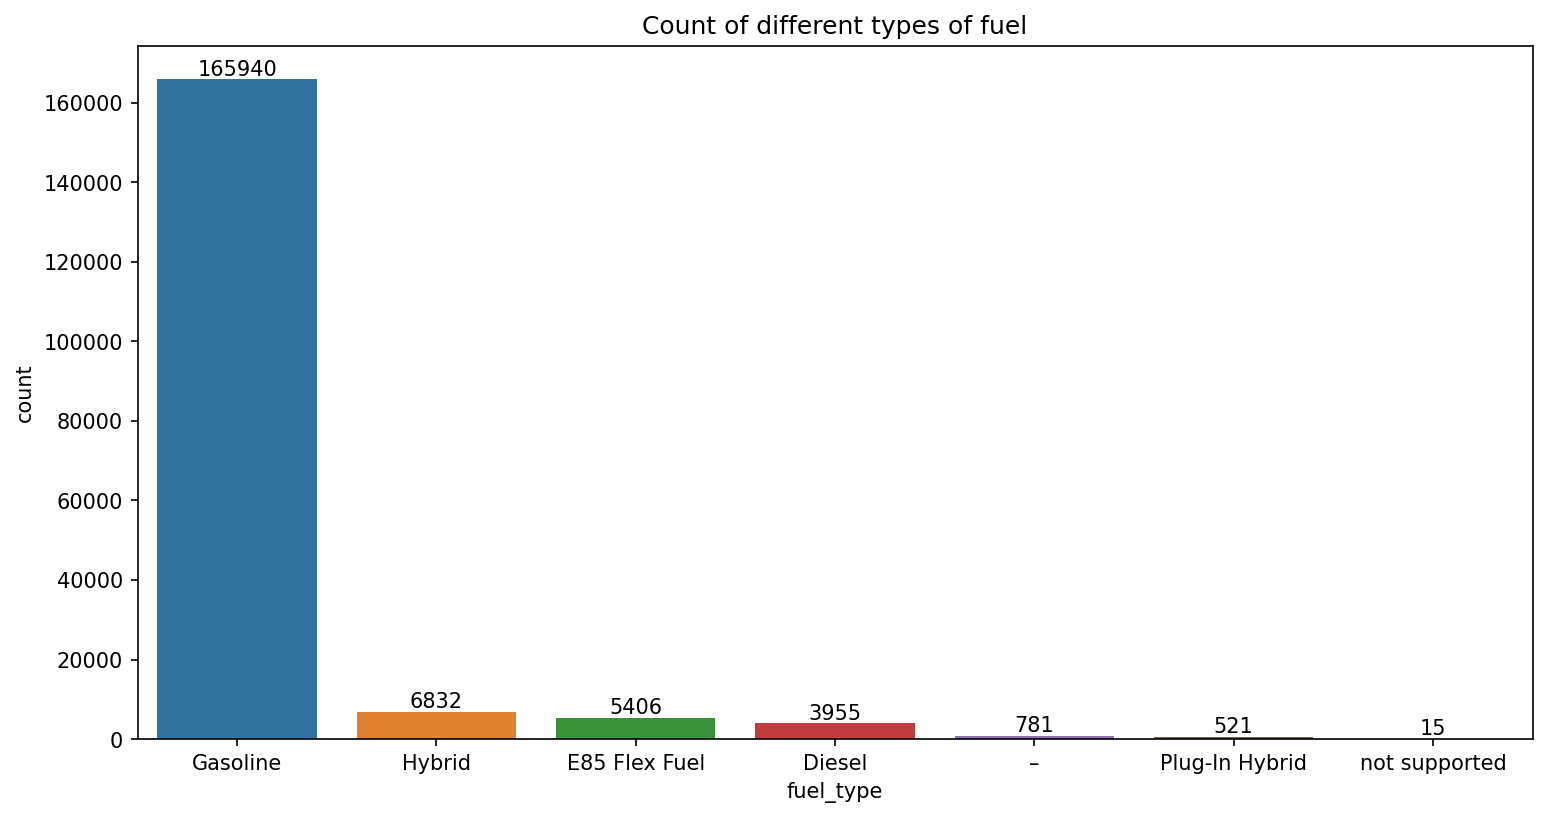

In [15]:
plot_count_plot(20, 'fuel_type', title='Count of different types of fuel', rotation='horizontal')

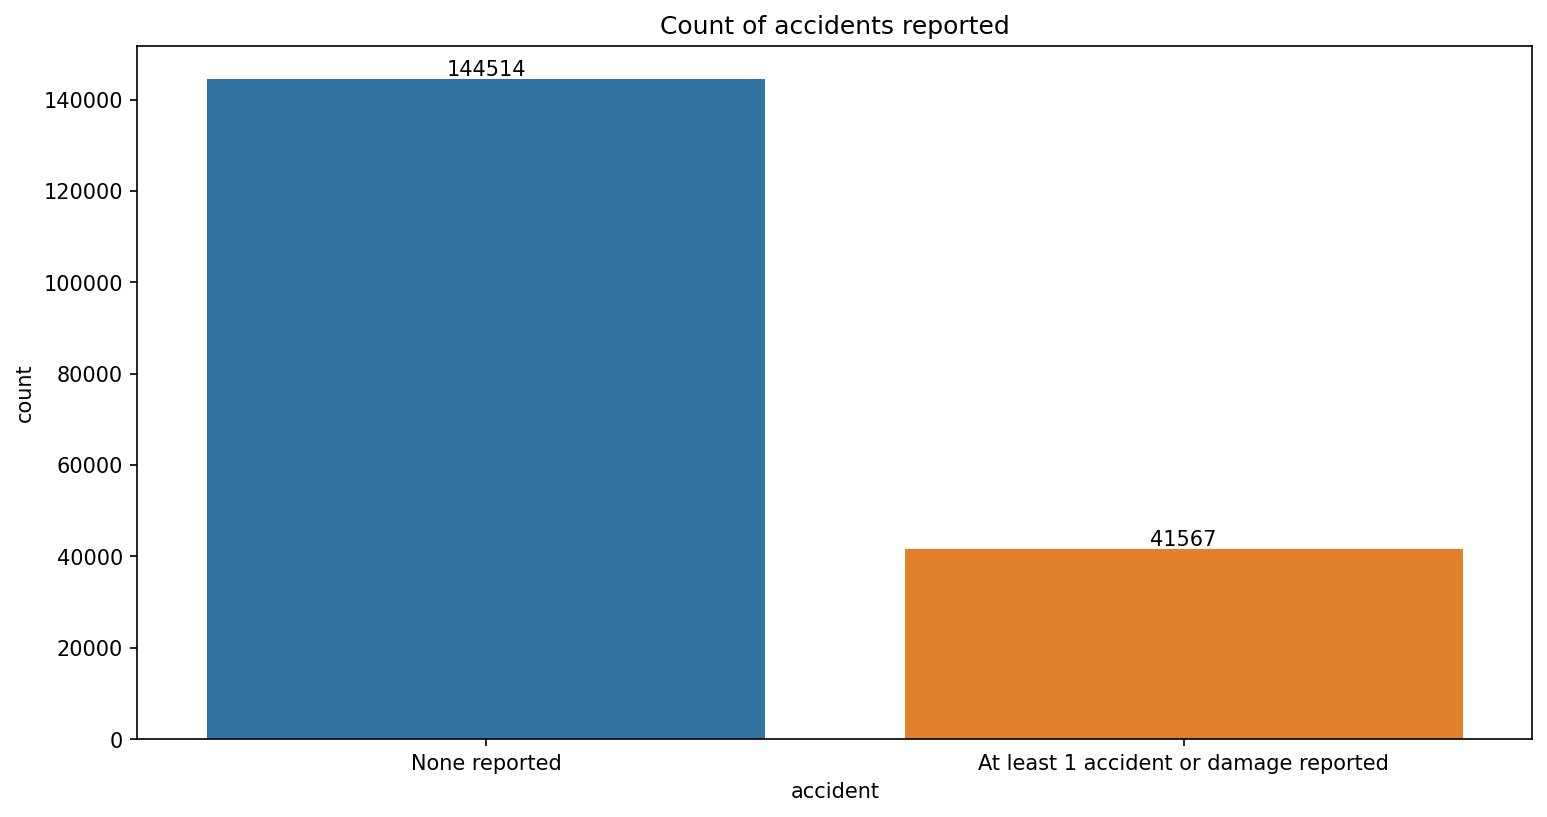

In [16]:
plot_count_plot(2, 'accident', title='Count of accidents reported', rotation='horizontal')

# Data cleaning and preprocessing

* fuel_type and accident columns has very less number of null values
* So, we will drop the rows that has null values in these two columns

In [17]:
train_df = train_df.dropna(subset=['fuel_type', 'accident'])

### Preprocessing the values in 'transmission' column

In [18]:
# Checking the unique values of transmissin column
train_df.transmission.unique()

array(['A/T', 'Transmission w/Dual Shift Mode', '7-Speed A/T',
       '8-Speed A/T', '10-Speed Automatic', '6-Speed A/T', '10-Speed A/T',
       '9-Speed A/T', '8-Speed Automatic', '9-Speed Automatic',
       '5-Speed A/T', '7-Speed Automatic with Auto-Shift', 'Automatic',
       'CVT Transmission', '5-Speed M/T', 'M/T', '6-Speed M/T',
       '6-Speed Automatic', '4-Speed Automatic', '7-Speed M/T',
       'Automatic CVT', '4-Speed A/T', '2-Speed A/T', '6-Speed Manual',
       'Transmission Overdrive Switch',
       '8-Speed Automatic with Auto-Shift', '7-Speed Manual',
       '7-Speed Automatic', '9-Speed Automatic with Auto-Shift',
       '1-Speed A/T', '6-Speed Automatic with Auto-Shift',
       '6-Speed Electronically Controlled Automatic with O', 'F', 'CVT-F',
       '8-Speed Manual', '1-Speed Automatic', 'Manual', '–', '2',
       '6 Speed At/Mt', '5-Speed Automatic', '2-Speed Automatic',
       '8-SPEED A/T', '7-Speed', 'Variable', 'Single-Speed Fixed Gear',
       '8-SPEED AT', 

In [19]:
# Function to categorize the transmission type
def categorize_transmission(value):
    if any(word in value for word in ['Automatic', 'A/T', 'CVT', 'F']):
        return 'Auto'
    elif any(word in value for word in ['Manual', 'M/T']):
        return 'Manual'
    else:
        return 'Auto-Manual'

In [20]:
train_df['transmission'] = train_df['transmission'].apply(categorize_transmission)

In [21]:
train_df['transmission'].value_counts()

transmission
Auto           145419
Auto-Manual     19529
Manual          16119
Name: count, dtype: int64

### Preprocessing the values in 'fuel_type' column

In [22]:
train_df.fuel_type.value_counts()

fuel_type
Gasoline          163853
Hybrid              6741
E85 Flex Fuel       5328
Diesel              3854
–                    764
Plug-In Hybrid       512
not supported         15
Name: count, dtype: int64

In [23]:
# Inspecting the values in 'engine' column for which the 'fuel_type' column has the value of '–'
train_df[train_df['fuel_type'] == '–']['engine']

532                                                   –
1155                                                  –
1307                                                  –
1362                                                  –
1741                                                  –
                              ...                      
187399                                                –
187495    284.0HP 3.5L V6 Cylinder Engine Gasoline Fuel
187664                                                –
187820                                                –
188189                                                –
Name: engine, Length: 764, dtype: object

In [24]:
# Dropping rows for which 'fuel_type' and 'engine' columns has the value '–'
train_df = train_df[(train_df['fuel_type'] != '–') & (train_df['engine'] != '–')]

In [25]:
# Inspecting the values in 'engine' column for which the 'fuel_type' column has the value of 'not supported'
train_df[train_df['fuel_type'] == 'not supported']['engine']

4823      320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...
18000          240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
19182                  182.0HP Electric Motor Hydrogen Fuel
27199          175.0HP 2.5L 4 Cylinder Engine Gasoline Fuel
33030                  182.0HP Electric Motor Hydrogen Fuel
60717          355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel
74096                  182.0HP Electric Motor Hydrogen Fuel
86897         311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel
94425          550.0HP 4.8L 8 Cylinder Engine Gasoline Fuel
127066                 151.0HP Electric Motor Hydrogen Fuel
128917         140.0HP 1.8L 4 Cylinder Engine Gasoline Fuel
135865                 182.0HP Electric Motor Hydrogen Fuel
140206        230.0HP 3.3L V6 Cylinder Engine Gasoline Fuel
171120         316.0HP 6.0L 8 Cylinder Engine Gasoline Fuel
171659                 182.0HP Electric Motor Hydrogen Fuel
Name: engine, dtype: object

In [26]:
# Function to categorize the fuel type
def categorize_fuel_type(row):
    fuel_type = row['fuel_type']
    engine = row['engine']

    if pd.notna(fuel_type) and pd.notna(engine):
        if any(word in fuel_type for word in ['Gasoline', 'Fuel', 'Diesel']) or 'Fuel' in engine:
            return 'Fuel'
        else:
            return 'Hybrid'
    else:
        return 'Unknown'

In [27]:
train_df['fuel_type'] = train_df.apply(categorize_fuel_type, axis=1)

In [28]:
train_df.fuel_type.value_counts()

fuel_type
Fuel      172953
Hybrid      7200
Name: count, dtype: int64

### Feature engineering from the values in 'engine' column

In [29]:
train_df['engine']

0              172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel
1              252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel
2         320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...
3              420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel
4              208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
                                ...                        
188528         420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel
188529        385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel
188530         469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel
188531                                                 3.0L
188532         252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
Name: engine, Length: 180153, dtype: object

In [30]:
# Function to extract the horse power of cylinders from the engine column
def extract_horse_power(engine_str):
    match = re.search(r'(\d+\.?\d*)HP', engine_str)
    if match:
        return float(match.group(1))
    else:
        return 0.0

In [31]:
# Function to extract the number of cylinders from the engine column
def extract_cylinders(engine_str):
    cylinder_pattern = r'(\d+)\s*Cylinder'
    v_pattern = r'V(\d+)'

    cylinder_match = re.search(cylinder_pattern, engine_str)
    v_match = re.search(v_pattern, engine_str)

    if cylinder_match:
        return int(cylinder_match.group(1))
    elif v_match:
        return int(v_match.group(1))
    else:
        return 0

In [32]:
# Function to extract the engine capacity from the engine column
def extract_engine_capacity(engine_str):
    litre_pattern = r'(\d+\.?\d*)\s*L'
    litre_word_pattern = r'(\d+\.?\d*)\s*litre'
    
    litre_match = re.search(litre_pattern, engine_str)
    litre_word_match = re.search(litre_word_pattern, engine_str)

    if litre_match:
        return float(litre_match.group(1))
    elif litre_word_match:
        return float(litre_word_match.group(1))
    else:
        return 0.0

In [33]:
train_df['horse_power'] = train_df['engine'].apply(extract_horse_power)
train_df['cylinders'] = train_df['engine'].apply(extract_cylinders)
train_df['engine_capacity'] = train_df['engine'].apply(extract_engine_capacity)

### Preprocessing the values in 'brand', 'ext_col' and 'int_col' columns

In [34]:
def keep_top_n_values(n, column, df):
    counts = df[column].value_counts()
    top_n_values = counts.head(n).index
    df.loc[~df[column].isin(top_n_values), column] = 'N/A'

In [35]:
keep_top_n_values(20, 'brand', train_df)
keep_top_n_values(10, 'ext_col', train_df)
keep_top_n_values(10, 'int_col', train_df)

# Separating features and labels

In [36]:
X = train_df.drop(['id', 'price', 'model', 'engine', 'clean_title'], axis=1)
y = train_df['price']

* In the above cell, we dropped the 'clean_title' column because it has only the value of "Yes". If we impute it, all the rows in that column will then have the same value. So, dropping this column will not affect the model predictions.

In [37]:
test_IDs = test_df['id']
X_test = test_df.drop(['id'], axis=1)

# Train-test-validation split

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=30)

# Encoding and scaling the data

In [39]:
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')
scaler = MinMaxScaler()

In [40]:
num_cols = [col for col in X_train.columns if X_train[col].dtype != object]
cat_cols_3_or_more = [col for col in X_train.columns if X_train[col].dtype == object and X_train[col].nunique() > 2]
cat_cols_2 = [col for col in X_train.columns if X_train[col].dtype == object and X_train[col].nunique() == 2]
cat_cols = cat_cols_2 + cat_cols_3_or_more

In [41]:
def encode(dataframe, cat_cols_3_or_more, cat_cols_2):
    dataframe = pd.get_dummies(dataframe, columns=cat_cols_3_or_more, dtype='int8')
    for col in cat_cols_2:
        vals = list(dict(dataframe[col].value_counts()).keys())
        mapping = {vals[0]: 0, vals[1]: 1}
        dataframe[col] = dataframe[col].map(mapping)
    return dataframe

In [42]:
def encode_impute_transform(dataframe, test_data=False):
    
    if not test_data:
        dataframe[num_cols] = numerical_imputer.fit_transform(dataframe[num_cols])
        dataframe[cat_cols] = categorical_imputer.fit_transform(dataframe[cat_cols])
        dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])
        dataframe = encode(dataframe, cat_cols_3_or_more, cat_cols_2)
        global train_columns
        train_columns = dataframe.columns
    
    elif test_data:
        dataframe[(dataframe['fuel_type'] != '–') & (dataframe['engine'] != '–')]
        dataframe['transmission'] = dataframe['transmission'].apply(categorize_transmission)
        dataframe['fuel_type'] = dataframe.apply(categorize_fuel_type, axis=1)
        dataframe['horse_power'] = dataframe['engine'].apply(extract_horse_power)
        dataframe['cylinders'] = dataframe['engine'].apply(extract_cylinders)
        dataframe['engine_capacity'] = dataframe['engine'].apply(extract_engine_capacity)
        dataframe = dataframe.drop(['engine', 'model'], axis=1)
        dataframe[num_cols] = numerical_imputer.transform(dataframe[num_cols])
        dataframe[cat_cols] = categorical_imputer.transform(dataframe[cat_cols])
        dataframe[num_cols] = scaler.transform(dataframe[num_cols])
        dataframe = encode(dataframe, cat_cols_3_or_more, cat_cols_2)
        for col in train_columns:
            if col not in dataframe.columns:
                dataframe[col] = 0
        dataframe = dataframe[train_columns]
    
    return dataframe

In [43]:
X_train_transformed = encode_impute_transform(X_train)
X_valid_transformed = encode_impute_transform(X_valid)
X_test_transformed = encode_impute_transform(X_test, test_data=True)

# Modelling

In [44]:
model = xgb.XGBRegressor(
    n_estimators=512,
    learning_rate=0.05,
    max_depth=16,
    subsample=0.5,
    min_child_weight=0.8,
    gamma=1e-6,
    early_stopping_rounds=5,
    objective='reg:squarederror',  # Objective for regression
    eval_metric='rmse',           # Evaluation metric for regression
    use_label_encoder=False,
)

In [45]:
model.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_valid_transformed, y_valid)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=1e-06, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=0.8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=512, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Model Insights

The below plot will show us the importance of each feature in the model. Features with higher importance scores contribute more to the model's predictions. The feature that we will be plotting is 'weight', which is the number of times a feature is used to split the data across all trees.

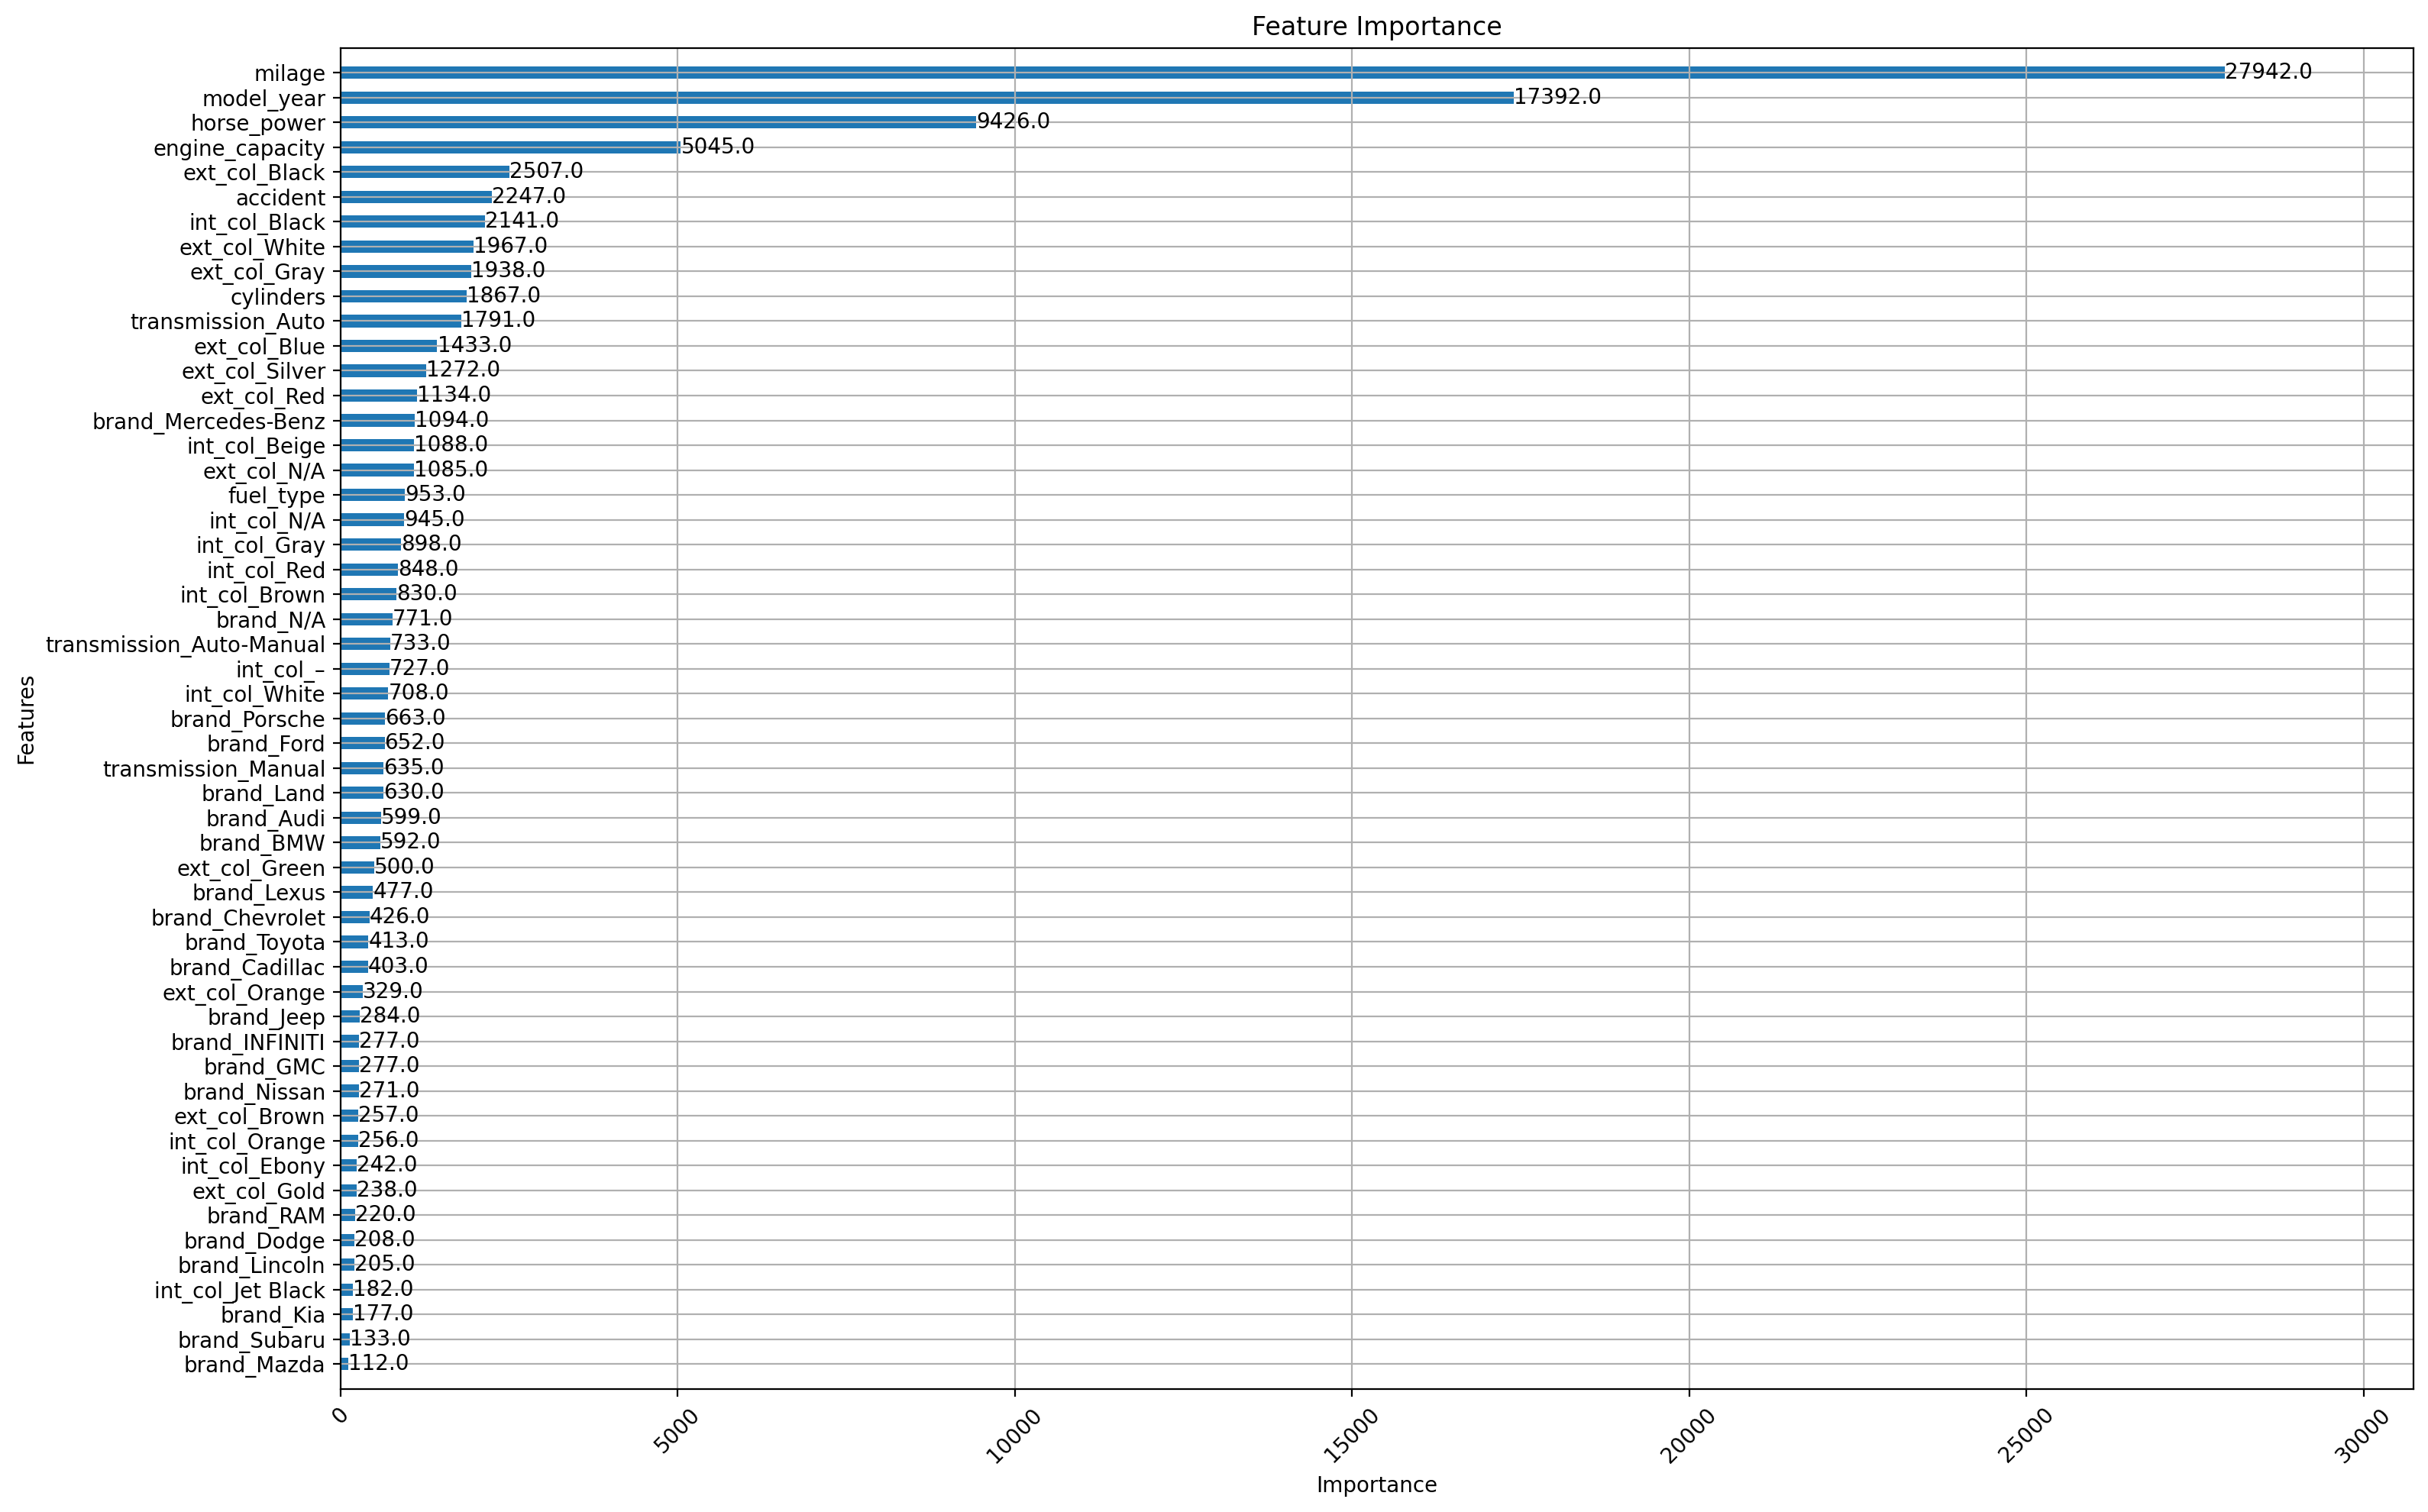

In [46]:
fig, ax = plt.subplots(figsize=(16, 10), dpi=200) 
xgb.plot_importance(model, importance_type='weight', title='Feature Importance', xlabel='Importance', ylabel='Features', height=0.5, ax=ax)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Model evaluation

In [47]:
score = np.sqrt(mean_squared_error(y_valid, model.predict(X_valid_transformed)))
print(f"The root mean squared error on the validation data is {round(score, 4)}.")

The root mean squared error on the validation data is 89410.4245.


# Making predictions

In [48]:
# Making predictions
preds = model.predict(X_test_transformed)

In [49]:
# Generaing submission file
submission_df = pd.DataFrame({'id': test_IDs, 'price': preds})
submission_df.to_csv('submission.csv', index=False)